Customer Life Time Value Prediction  LTV

**Customer Lifetime Value (CLV) is the total monetary value of transactions/purchases made by a customer with your business over his entire lifetime

 Here the lifetime means the time period till your customer purchases with you before moving to your competitors.**




**Machine Learning Model for Golden Metric (Life Time Value) Prediction**`




In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import datetime
from datetime import datetime, timedelta,date
import matplotlib.pyplot as plt
%matplotlib inline
import time
import seaborn as sns

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, auc, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import  KMeans, AgglomerativeClustering
import random
from sklearn.metrics import silhouette_score
random.seed(42)

from __future__ import division

# warnings ignored
import warnings
warnings.filterwarnings("ignore")

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

**Following code is to get plotly images in Colab**

In [2]:
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

**plotly setup**

In [3]:
# ploty setup
import plotly 
from plotly import __version__
print(__version__)
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.offline as pyoff
from plotly.offline import  init_notebook_mode , plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected = True)

import plotly.figure_factory as ff

!pip install chart-studio
import chart_studio.plotly as py

4.4.1


     |████████████████████████████████| 71kB 3.0MB/s 


In [4]:
# Load Data
retail = pd.read_excel("/content/online_retail_normalized (2).xlsx")
retail.sample(2, random_state = 42)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,CancelledQuantity,TotalPrice
85446,547656,21166,COOK WITH WINE METAL SIGN,3,2011-03-24 12:53:00,2.08,13263,United Kingdom,0,6.24
164784,557960,22170,PICTURE FRAME WOOD TRIPLE PORTRAIT,1,2011-06-23 19:46:00,6.75,15453,United Kingdom,0,6.75


In [6]:
retail.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country', 'CancelledQuantity',
       'TotalPrice'],
      dtype='object')

In [7]:
retail = retail.drop(['CancelledQuantity', 'TotalPrice'],axis = 1)
retail.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

# United Kingdom

# Customer Life Time Value Prediction  (UK)



**United Kingdom Only**

`since from exploratory analysis shows that revenue generated by UK is quite high as compare to another countries`

In [8]:
retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'])

In [9]:
# Filter the data to UK only
uk = retail.query("Country=='United Kingdom'").reset_index(drop=True)
uk['InvoiceDate'] = pd.to_datetime(uk['InvoiceDate'])

**we wil take 3 months of data, calculate RFM and use it for predicting next 6 months.**

`so divide the whole dataset in to 3 months and 6 months in the form of dataframe and then apply RFM score to this`

In [10]:
# create 3 Months and 6 Months DataFrame
uk_3m = uk[(uk.InvoiceDate < datetime(2011,6,1)) & (uk.InvoiceDate >= datetime(2011,3,1))].reset_index(drop=True)
uk_6m = uk[(uk.InvoiceDate >= datetime(2011,6,1)) & (uk.InvoiceDate < datetime(2011,12,1))].reset_index(drop=True)

#create uk_customer for assigning clustering
uk_user = pd.DataFrame(uk_3m['CustomerID'].unique())
uk_user.columns = ['CustomerID']

#order cluster method
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

#calculate recency score
uk_max_purchase = uk_3m.groupby('CustomerID').InvoiceDate.max().reset_index()
uk_max_purchase.columns = ['CustomerID','MaxPurchaseDate']
uk_max_purchase['Recency'] = (uk_max_purchase['MaxPurchaseDate'].max() - uk_max_purchase['MaxPurchaseDate']).dt.days
uk_user = pd.merge(uk_user, uk_max_purchase[['CustomerID','Recency']], on='CustomerID')

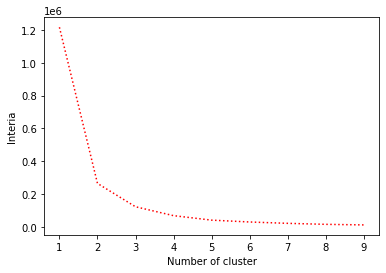

In [11]:
from sklearn.cluster import KMeans

sse={}
uk_recency = uk_user[['Recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(uk_recency)
    uk_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()), linestyle = 'dotted',  color  = 'red')
plt.xlabel("Number of cluster")
plt.ylabel("Interia")
plt.show()

In [12]:
score_list = []
list1 = [2,3,4,5,6,7,8, 9, 10, 11,12]
for n_clusters in list1 :
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(uk_recency)

    silhouette_avg = silhouette_score(uk_recency, cluster_labels)
    score_list.append(silhouette_avg)
    #print("For n_clusters =", n_clusters,   "The average silhouette_score is :", silhouette_avg)
print(score_list)

[0.672803591840073, 0.6186431618723158, 0.5856133763670808, 0.5766457068106826, 0.5945603085878847, 0.5608803721368444, 0.6182841095532178, 0.6510413892497892, 0.6502334377618696, 0.6506751812182388, 0.6443798626018006]


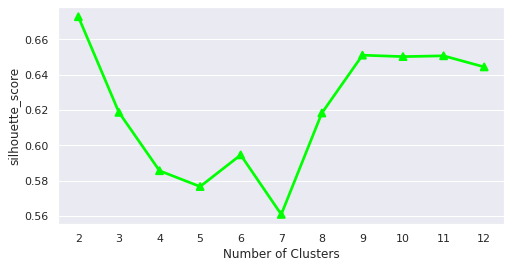

In [13]:
silhouette_df  = pd.DataFrame(score_list,index = list1)
silhouette_df.rename(columns={0:'silhouette_score'}, inplace= True)

plt.figure(figsize=(8,4))
sns.set_theme(style= 'darkgrid')
ax = sns.pointplot(x = list1, y = 'silhouette_score', data = silhouette_df, linestyle = '--', color = 'lime',markers = '^' )
ax.set(xlabel = 'Number of Clusters')
plt.show()

**Elbow plot representing 3 and 4 optimal number of clusters, i will take 4, silhoutee is also giving the 4, purpose of silhoutte analysis is to ensure the value given by k-means.here.**

In [14]:
# K means on recency to find recency clusters
kmeans = KMeans(n_clusters=4,random_state=42)
kmeans.fit(uk_user[['Recency']])

uk_user['RecencyCluster'] = kmeans.predict(uk_user[['Recency']])

In [15]:
uk_user.groupby('RecencyCluster')['Recency'].describe()

,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,463.0,24.382289,4.940629,17.0,20.0,23.0,27.0,35.0
1,348.0,76.635057,8.396282,64.0,69.0,75.0,84.0,91.0
2,432.0,50.296296,7.265606,39.0,44.0,50.0,56.0,63.0
3,563.0,8.674956,4.467661,0.0,5.0,9.0,12.0,16.0


**Observation of recency Cluster** 
from the recency cluster it is clear The customers in Cluster 1 are very recent compared to Cluster 2. this is wrong k -means assigns clusters but not in ordered way, so there is need to write function to address this issue.

In [16]:
# apply function
uk_user = order_cluster('RecencyCluster', 'Recency',uk_user,False)
uk_user.groupby('RecencyCluster')[['Recency']].describe()

Recency                                                   
                 count       mean       std   min   25%   50%   75%   max
RecencyCluster                                                           
0                348.0  76.635057  8.396282  64.0  69.0  75.0  84.0  91.0
1                432.0  50.296296  7.265606  39.0  44.0  50.0  56.0  63.0
2                463.0  24.382289  4.940629  17.0  20.0  23.0  27.0  35.0
3                563.0   8.674956  4.467661   0.0   5.0   9.0  12.0  16.0

**Observation from Recececy after application of Function**

3 Covers most recent customers and 1 covers inactive customers.


**Frequency calculation**

In [17]:
#calcuate frequency score
uk_frequency = uk_3m.groupby('CustomerID').InvoiceDate.count().reset_index()
uk_frequency.columns = ['CustomerID','Frequency']

In [18]:
uk_frequency.head()

,CustomerID,Frequency
0,12747,35
1,12748,522
2,12749,43
3,12821,6
4,12823,1


In [19]:
uk_user = pd.merge(uk_user, uk_frequency, on='CustomerID')
uk_user.head()


,CustomerID,Recency,RecencyCluster,Frequency
0,14620,13,3,26
1,14740,4,3,89
2,17068,11,3,76
3,12971,4,3,73
4,15194,6,3,60


In [20]:
# K-means on Frequceny to find frequency Clusters
kmeans = KMeans(n_clusters=4,random_state=42)
kmeans.fit(uk_user[['Frequency']])
uk_user['FrequencyCluster'] = kmeans.predict(uk_user[['Frequency']])

uk_user = order_cluster('FrequencyCluster', 'Frequency',uk_user,True)

In [21]:

#calcuate revenue score
uk_3m['Revenue'] = uk_3m['UnitPrice'] * uk_3m['Quantity']
uk_revenue = uk_3m.groupby('CustomerID').Revenue.sum().reset_index()
uk_user = pd.merge(uk_user, uk_revenue, on='CustomerID')

In [22]:

kmeans = KMeans(n_clusters=4,random_state=42)
kmeans.fit(uk_user[['Revenue']])
uk_user['RevenueCluster'] = kmeans.predict(uk_user[['Revenue']])

uk_user = order_cluster('RevenueCluster', 'Revenue',uk_user,True)
uk_user.sample(3, random_state=42)

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster
1368,15935,47,1,12,0,416.86,0
65,17591,11,3,33,0,781.86,0
700,15421,23,2,25,0,444.30,0


**Segment Customer based on their RFM score**

In [23]:
#Overall scoring
uk_user['OverallScore'] = uk_user['RecencyCluster'] + uk_user['FrequencyCluster'] + uk_user['RevenueCluster']
uk_user['Segment'] = 'Low-Value'
uk_user.loc[uk_user['OverallScore']>2,'Segment'] = 'Mid-Value' 
uk_user.loc[uk_user['OverallScore']>4,'Segment'] = 'High-Value' 
uk_user.sample(5, random_state= 42)

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
1368,15935,47,1,12,0,416.86,0,1,Low-Value
65,17591,11,3,33,0,781.86,0,3,Mid-Value
700,15421,23,2,25,0,444.30,0,2,Low-Value
938,13708,79,0,49,0,285.33,0,0,Low-Value
1621,17954,34,2,83,1,470.84,0,3,Mid-Value


In [24]:
score_df = uk_user.groupby('OverallScore')[['Frequency', 'Recency', 'Revenue']].agg('mean')
score_df

,Frequency,Recency,Revenue
OverallScore,,,
0,18.525836,76.802432,305.210274
1,24.771084,51.486747,389.181229
2,29.637850,26.553738,509.686963
3,36.135667,10.936543,708.731094
4,97.463415,9.520325,2047.523585
5,119.111111,7.444444,4002.273889
6,314.333333,8.133333,11559.810667
7,743.000000,3.666667,11567.396667


**observation** 

The scoring or ranking above clearly shows us that customers with score 7 is our best customers whereas 0 is the worst.

#### Segments Charts

In [25]:
#Revenue vs Frequency
configure_plotly_browser_state()
init_notebook_mode(connected=False)

uk_graph = uk_user.query("Revenue < 50000 and Frequency < 2000")

trace1 = [
    go.Scatter(
        x=uk_graph.query("Segment == 'Low-Value'")['Frequency'],
        y=uk_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'brown',
            opacity= 0.8)
           
    ),
        go.Scatter(
        x=uk_graph.query("Segment == 'Mid-Value'")['Frequency'],
        y=uk_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'silver',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=uk_graph.query("Segment == 'High-Value'")['Frequency'],
        y=uk_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'gold',
            opacity= 0.9
           )
    ),
] 
        
plot_layout = go.Layout(xaxis_title= 'Frequency', yaxis_title= 'Revenue', title = 'Revencue vs Frequency', width = 600, height = 400, font=dict(     
        color="magenta") )  
fig = go.Figure(data=trace1, layout=plot_layout)
iplot(fig)   

Output hidden; open in https://colab.research.google.com to view.

In [26]:

#Revenue Recency
configure_plotly_browser_state()
init_notebook_mode(connected=False)

uk_graph = uk_user.query("Revenue < 50000 and Frequency < 2000")

trace = [
    go.Scatter(
        x=uk_graph.query("Segment == 'Low-Value'")['Recency'],
        y=uk_graph.query("Segment == 'Low-Value'")['Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'brown',
            opacity= 0.7
           )
    ),
        go.Scatter(
        x=uk_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=uk_graph.query("Segment == 'Mid-Value'")['Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'silver',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=uk_graph.query("Segment == 'High-Value'")['Recency'],
        y=uk_graph.query("Segment == 'High-Value'")['Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'gold',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(xaxis_title= 'Recency', yaxis_title= 'Revenue', title = 'Revenue vs Recency', width = 800, height = 400, font=dict(     
        color="magenta") )  
fig = go.Figure(data=trace1, layout=plot_layout)
iplot(fig) 

Output hidden; open in https://colab.research.google.com to view.

**Recency vs Frequency**

In [27]:
configure_plotly_browser_state()
init_notebook_mode(connected=False)

uk_graph = uk_user.query("Revenue < 50000 and Frequency < 2000")

trace = [
    go.Scatter(
        x=uk_graph.query("Segment == 'Low-Value'")['Recency'],
        y=uk_graph.query("Segment == 'Low-Value'")['Frequency'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'brown',
            opacity= 0.9)         
    ),
        go.Scatter(
        x=uk_graph.query("Segment == 'Mid-Value'")['Recency'],
        y=uk_graph.query("Segment == 'Mid-Value'")['Frequency'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'silver',
            opacity= 0.5)  
    ),
        go.Scatter(
        x=uk_graph.query("Segment == 'High-Value'")['Recency'],
        y=uk_graph.query("Segment == 'High-Value'")['Frequency'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'gold',
            opacity= 0.9)   
    ),]

plot_layout = go.Layout(xaxis_title = 'Recency', yaxis_title = 'Frequency', title='Recency vs Frequency', width = 800, height = 400)   
fig = go.Figure(data=trace, layout=plot_layout)
pyoff.iplot(fig)

Output hidden; open in https://colab.research.google.com to view.

**Conclusion From Segmentations**

`Low Segment customers`: Customers who are not very frequent buyer/visitor and generates very low - zero - maybe negative revenue.

`Mid Segment Customers`: This is group of customers who generates moderate revenue   Often using our platform (but not as much as our High Values), fairly frequent and generates moderate revenue.

`High Segment Customers`: This is the group of  customers that business never want to loose since they are generating High Revenue, Frequency and show high activity.


# 6 months Life Time Value for each customer -- for training different models.

In [28]:

#calculate revenue and create a new dataframe for it
configure_plotly_browser_state()

uk_6m['Revenue'] = uk_6m['UnitPrice'] * uk_6m['Quantity']
uk_user_6m = uk_6m.groupby('CustomerID')['Revenue'].sum().reset_index()
uk_user_6m.columns = ['CustomerID','m6_Revenue']

#plot LTV histogram
trace_data = [
    go.Histogram(
        x=uk_user_6m.query('m6_Revenue < 10000')['m6_Revenue'], marker = dict(color = 'mediumorchid',
                             line=dict(color='rgb(233,0,200)',)
                                                          ), nbinsy = 30
    )
]

trace_layout = go.Layout(width = 800, height= 400,  title='6month Revenue')
    
fig = go.Figure(data=trace_data, layout=trace_layout)
iplot(fig)

`**Merge our 3 months and 6 months dataframes to see correlations between LTV and predictors **`

In [29]:
configure_plotly_browser_state()

uk_merge = pd.merge(uk_user, uk_user_6m, on='CustomerID', how='left')
uk_merge = uk_merge.fillna(0)

uk_graph = uk_merge.query("m6_Revenue < 30000")


data1 = [
    go.Scatter(
        x=uk_graph.query("Segment == 'Low-Value'")['OverallScore'],
        y=uk_graph.query("Segment == 'Low-Value'")['m6_Revenue'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'lime',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=uk_graph.query("Segment == 'Mid-Value'")['OverallScore'],
        y=uk_graph.query("Segment == 'Mid-Value'")['m6_Revenue'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'firebrick',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=uk_graph.query("Segment == 'High-Value'")['OverallScore'],
        y=uk_graph.query("Segment == 'High-Value'")['m6_Revenue'],
        mode='markers',
        name='High',
        marker= dict(size= 12,
            line= dict(width=1),
            color= 'gold',
            opacity= 0.9
           )
    ),
]

trace_layout = go.Layout(
        yaxis= {'title': "6month LTV"},
        xaxis= {'title': "RFM Score"},
        title='Customer Life Time Value', font = dict(color = 'blue', family="Courier New, monospace",
        size=20), plot_bgcolor='rgba(0,0,0,80)', width = 800, height = 350
    )
fig = go.Figure(data=data1, layout=trace_layout)
iplot(fig)


**WE need to treat customers differently based on their predicted LTV**


**Observation**  `high RFM score, high LTV


# Outliers detection and removal for achiveing good model

In [30]:

uk_merge[uk_merge['m6_Revenue']==0].shape # count zero vales in Revenue

(452, 10)

In [31]:
uk_merge[uk_merge['m6_Revenue']<0].shape # count of negitive values in revenue

(0, 10)

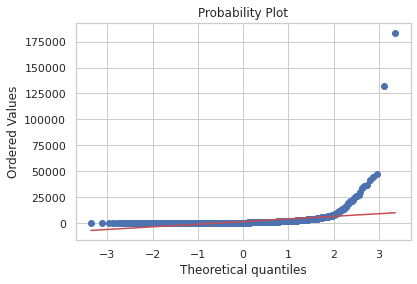

In [32]:
# q-q plot before removing outilers
import scipy.stats as stats
plt.figure(figsize = (6 ,4))
sns.set_theme(style ='whitegrid')
stats.probplot(uk_merge['m6_Revenue'], dist="norm", plot = plt)
plt.show()


 `**we need to predict customers based on their LTV segments, for that apply k_means clustering, and various classification models can be applied on all segments**`

In [33]:
#remove outliers
uk_merge = uk_merge[uk_merge['m6_Revenue']<uk_merge['m6_Revenue'].quantile(0.99)]
print(uk_merge.shape)

(1787, 10)


In [34]:
#creating 3 clusters
kmeans = KMeans(n_clusters=3,random_state= 42)
kmeans.fit(uk_merge[['m6_Revenue']])
uk_merge['LTVlabels'] = kmeans.predict(uk_merge[['m6_Revenue']])

#order cluster number based on LTV
uk_merge = order_cluster('LTVlabels', 'm6_Revenue',uk_merge,True)

In [35]:
#creating new cluster dataframe
uk_cluster = uk_merge.copy()

In [36]:
#see details of the clusters
uk_cluster.groupby('LTVlabels')['m6_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVlabels,,,,,,,,
0,1407.0,438.525822,458.240823,0.00,0.000,315.69,750.075,1583.92
1,331.0,2728.160302,1024.121700,1595.64,1922.125,2342.91,3328.180,5773.13
2,49.0,8872.027755,3104.440866,5873.90,6390.120,7457.55,11072.650,17101.04


`**label number 2 is the best with high mean and 1 is the worst with lowest means**`

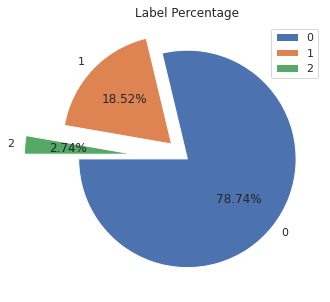

In [37]:

plt.figure(figsize=(5,5))
plt.pie(uk_cluster["LTVlabels"].value_counts(), labels = uk_cluster["LTVlabels"].unique(), startangle = 180, explode = [0,0.2,0.5], autopct = "%1.2f%%")
plt.title("Label Percentage")
plt.legend()
plt.show()

### Convert categorical features to numerical before fitting the training set

In [38]:

#convert categorical columns to numerical
uk_class = pd.get_dummies(uk_cluster)

In [39]:
uk_class.sample(2)

,CustomerID,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,m6_Revenue,LTVlabels,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
1027,14419,60,1,36,0,183.04,0,1,744.65,0,0,1,0
1044,14023,57,1,16,0,273.14,0,1,0.00,0,0,1,0


**Correlation Check**

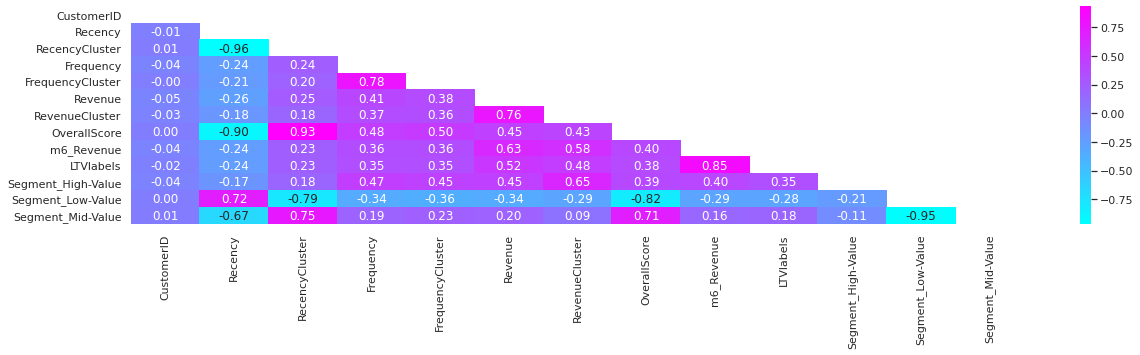

In [40]:
#calculate and show correlations
corr_matrix = uk_class.corr()
mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (20, 4))
sns.heatmap(corr_matrix, annot = True, fmt = '.2f', cmap= 'cool', mask = mask)
plt.show()

# Check and prepare Data Before Model building

* Normalized predictors
* outliers
* multicollinearity



In [41]:
#plot the histogram
configure_plotly_browser_state()
plot_data = [go.Histogram(x=uk_user.query('Frequency < 1000')['Frequency'])]
    
plot_layout = go.Layout( title='Customer Frequency', width = 650, height = 400)
    
fig = go.Figure(data=plot_data, layout=plot_layout)
iplot(fig)

In [42]:
configure_plotly_browser_state()

#plot the Revenue Histogram
trace_data = [go.Histogram(x=uk_user.query('Revenue < 10000')['Revenue'])]   
plot_layout = go.Layout( title='Monetary Value', width = 650, height = 400)
    
fig = go.Figure(data=trace_data, layout=plot_layout)
iplot(fig)

In [43]:
configure_plotly_browser_state()
init_notebook_mode(connected=False)
#plot a recency histogram
plot_data = [go.Histogram( x=uk_user['Recency'] , nbinsy= 30)]

plot_layout = go.Layout( title='Customer Recency', yaxis= {'title': "Total Number of Transactions"},xaxis= {'title': "Recency in Days"}, width = 650, height = 400)
                       
fig = go.Figure(data=plot_data, layout=plot_layout)
iplot(fig)

Output hidden; open in https://colab.research.google.com to view.

**Transformations to recency, frequency and revenue for Normal Distribution**

In [46]:
# above histogram shows that revenue has negative values, it must be removed since they are retruned tractions according to exploratory analysis
uk_class = uk_class[(uk_class['Revenue']>0)]

uk_class.reset_index(drop = True, inplace = True)
uk_class[['Revenue']].count()

Revenue    1787
dtype: int64

In [47]:
uk_class[uk_class['Revenue']<0].count()

CustomerID            0
Recency               0
RecencyCluster        0
Frequency             0
FrequencyCluster      0
Revenue               0
RevenueCluster        0
OverallScore          0
m6_Revenue            0
LTVlabels             0
Segment_High-Value    0
Segment_Low-Value     0
Segment_Mid-Value     0
dtype: int64

**Transformations to get normalized data for model building**

In [48]:
uk_class['Frequency'] = uk_class['Frequency'].apply(np.log)
uk_class['Recency']   =  uk_class['Recency'].apply(np.sqrt)
uk_class['Revenue']   =  uk_class['Revenue'].apply(np.log)

**Distplot for checking the distribution after transformation**

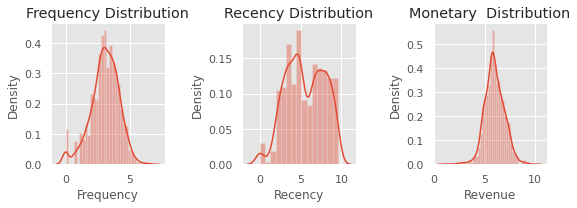

In [49]:
plt.style.use("ggplot")
#plotting the distribution
plt.figure(figsize=(8,3))
plt.subplot(131)
sns.distplot(uk_class["Frequency"])
plt.title("Frequency Distribution")
plt.subplot(132)
sns.distplot(uk_class["Recency"])
plt.title("Recency Distribution")
plt.subplot(133)
sns.distplot(uk_class["Revenue"])
plt.title("Monetary  Distribution")
plt.tight_layout()

**Separate independent variables and  split the data in to `training and testing parts`**

In [54]:
#create X and y, X will be feature set and y is the label - LTV
X = uk_class.drop(['LTVlabels','m6_Revenue'],axis=1)
y = uk_class['LTVlabels']

#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1697, 11) (90, 11) (1697,) (90,)


In [73]:
X.columns

Index(['CustomerID', 'Recency', 'RecencyCluster', 'Frequency',
       'FrequencyCluster', 'Revenue', 'RevenueCluster', 'OverallScore',
       'Segment_High-Value', 'Segment_Low-Value', 'Segment_Mid-Value'],
      dtype='object')

Accuracy is not good measure in case of classification model, precison , recall gives better results that we can find from classification report


# Hyperparameter Tunning

* For accurate predictions GridSearchCV is used



`**Random_state = 42 and cv = 5 for all Classifiers**`

# XGBClassifier()

In [74]:
# default Xgboost classifier
t1 = time.time()
default_gbc =  xgb.XGBClassifier(max_depth = 1, random_state=42).fit(X_train, y_train)
d_gbc_time = time.time() - t1
d_gbc_y = default_gbc.predict(X_test)
gbc_acc = round(accuracy_score(y_test, d_gbc_y)*100, 2)
gbc_acc

87.78

**GridSearch CV for Xboost Classifier**

In [75]:
from sklearn.model_selection import GridSearchCV

In [76]:
# parameters for xgboost classifier
param_gbc = {
 'max_depth':range(3,20,2),
 'min_child_weight':range(1,3,1),
 'subsample': [0.5, 0.7]
}

import time
time1 =  time.time()
gsearch_gbc = GridSearchCV(estimator = xgb.XGBClassifier(random_state=42), param_grid = param_gbc, scoring='accuracy',n_jobs=-1,iid=False, cv=5).fit(X_train, y_train)

             
gbc_best_params = gsearch_gbc.best_params_
gbc_params_df = pd.DataFrame.from_dict(gbc_best_params, orient = 'index')
gbc_params_df.rename(columns = {0:'Xgboost_params'}, inplace = True)

gbc_best_score =  gsearch_gbc.best_score_

gbc_best_score = round(gbc_best_score*100,2)
print(gbc_best_score)
gbc_params_df

81.02


,Xgboost_params
max_depth,3.0
min_child_weight,2.0
subsample,0.5


# Random Forest Classifier

In [77]:
# default RandomForest classifier
t1 = time.time()
default_ran = RandomForestClassifier(criterion = 'entropy', max_depth = 1, min_samples_split = 5, min_samples_leaf= 1, max_samples = 2,  random_state=42).fit(X_train, y_train)
d_ran_time = time.time() - t1
d_ran_y = default_ran.predict(X_test)
ran_acc = round(accuracy_score(y_test, d_ran_y)*100, 2)
ran_acc

78.89

**Grid Search CV for Random Forest**



In [78]:
param_ran = { 'n_estimators':[4, 6, 7],  'criterion':['gini', 'entropy'], 'max_depth':np.arange(3,20), 'min_samples_split':np.arange(2,8),
             
                        'max_samples' : np.arange(2,8)}
# Grid Search                         
gsearch_ran = GridSearchCV(estimator = RandomForestClassifier(random_state = 42), param_grid= param_ran, n_jobs= -1, cv = 5).fit(X_train, y_train)
ran_best_params = gsearch_ran.best_params_
ran_params_df = pd.DataFrame.from_dict(ran_best_params, orient = 'index')
ran_params_df.rename(columns = {0:'RandomForest_params'}, inplace = True)
ran_best_score =  gsearch_ran.best_score_  
ran_best_score = round(ran_best_score*100,2)
ran_params_df 

,RandomForest_params
criterion,gini
max_depth,3
max_samples,7
min_samples_split,7
n_estimators,6


# ExtraTreeClassifier

In [79]:
# default ExtraTree classifier
random_state = 42
t1 = time.time()
default_extra = ExtraTreesClassifier(max_depth = 3, max_features = 'auto',random_state=42).fit(X_train, y_train)
d_extra_time = time.time() - t1
d_extra_y = default_extra.predict(X_test)
extra_acc = round(accuracy_score(y_test, d_extra_y)*100, 2)
extra_acc

83.33

In [80]:
default_extra

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=3, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=42, verbose=0,
                     warm_start=False)

**Grid Search CV for Extra Tree Classifier**



In [81]:
# GridSearch CV
param_extra={
        'max_depth':np.arange(3,25), 'max_features':np.arange(3, 9),
                    
                    'min_samples_leaf':[1, 4, 5, 15], 'min_samples_split':np.arange(2,6)
    }
gsearch_extra = GridSearchCV(estimator = ExtraTreesClassifier(random_state=42), param_grid= param_extra, n_jobs= -1, cv = 5).fit(X_train, y_train)

extra_best_params = gsearch_extra.best_params_
extra_params_df = pd.DataFrame.from_dict(extra_best_params, orient = 'index')
extra_params_df.rename(columns={0:'ExtraTree_params'}, inplace = True)
extra_best_score =  gsearch_extra.best_score_  
extra_best_score = round(extra_best_score*100,2)
extra_params_df

,ExtraTree_params
max_depth,7
max_features,8
min_samples_leaf,1
min_samples_split,3


**Grid Seach For KNN Classifier**

In [82]:
# default knn
t1 = time.time()
default_knn =KNeighborsClassifier(n_neighbors=2).fit(X_train, y_train)
d_knn_time = time.time() - t1
d_knn_y = default_knn.predict(X_test)
knn_acc = accuracy_score(y_test, d_knn_y)
knn_acc =round(knn_acc*100,2)

In [83]:
# Grid Search for KNN
param_knn = {'leaf_size':np.arange(1,5), 'n_neighbors' :np.arange(1,8)}
random_state = 42
gsearch_knn = GridSearchCV(estimator= KNeighborsClassifier(), param_grid= param_knn).fit(X_train, y_train)
knn_best_params = gsearch_knn.best_params_
knn_params_df = pd.DataFrame.from_dict(knn_best_params, orient = 'index')
knn_params_df.rename(columns={0:'knn_params'}, inplace = True)
knn_best_score =  round(gsearch_knn.best_score_ , 2) 
knn_best_score = round(knn_best_score*100,2)
knn_params_df

,knn_params
leaf_size,1
n_neighbors,6


In [91]:
# Extra Tree (time and predictions)
import time
time_extra = time.time()
y_pred_tree = gsearch_extra.predict(X_test)
tree_time = (time.time() - time_extra)
print("Time for Extra Tree", tree_time )

Time for Extra Tree 0.021077871322631836


In [92]:
# time and predictions for Xgboost
time_gbc = time.time()
y_pred_gbc = gsearch_gbc.predict(X_test)
gbc_time = (time.time() - time_gbc)
print("Time for Extra Tree", gbc_time)

Time for Extra Tree 0.0045168399810791016


In [93]:
time_ran = time.time() 
y_pred_ran = gsearch_ran.predict(X_test)
ran_time = (time.time() - time_extra)
print("Time for RandomForest", ran_time)

Time for RandomForest 2.6458184719085693


In [94]:
time_ran = time.time()
y_pred_knn = gsearch_knn.predict(X_test)
knn_time = (time.time() - time_extra)
print("Time for KNN", knn_time)

Time for KNN 3.385810613632202


 # Learning Curves 

 by using the parameters given by GridSearch

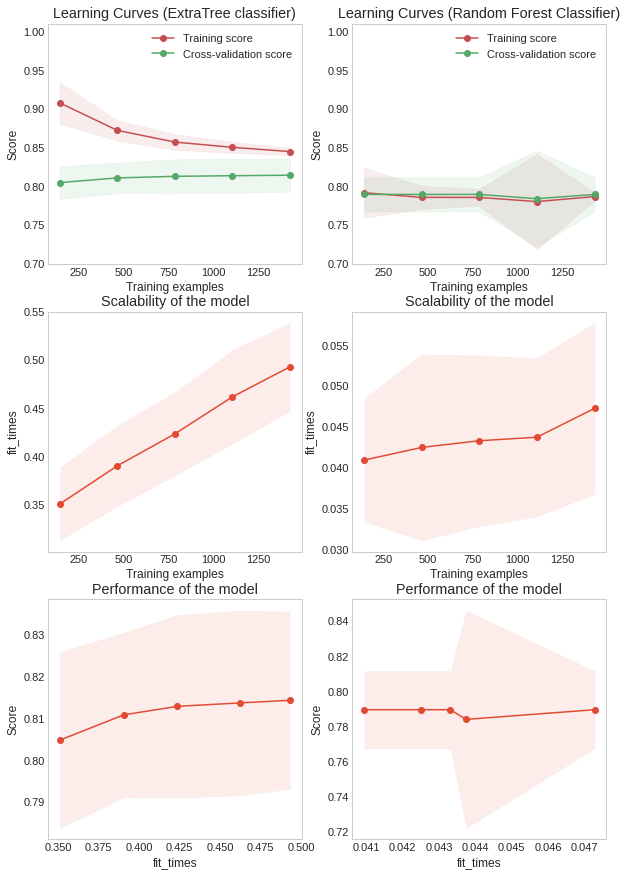

In [95]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
plt.style.use('seaborn-whitegrid')

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
  if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

  axes[0].set_title(title)
  if ylim is not None:

    axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)


    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X = uk_class.drop(['LTVlabels','m6_Revenue'],axis=1)
y = uk_class['LTVlabels']

title = "Learning Curves (ExtraTree classifier)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = ExtraTreesClassifier(max_depth= 6,max_features = 7,min_samples_leaf=1 ,min_samples_split = 5, random_state=42
 )
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

title = r"Learning Curves (Random Forest Classifier)"
# 
clf = RandomForestClassifier(n_estimators=7, criterion= 'entropy', max_samples =  3,
min_samples_leaf =1,min_samples_split =7,max_depth=7, random_state=42).fit(X_train, y_train)
estimator = clf 
#estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=4)

plt.show()

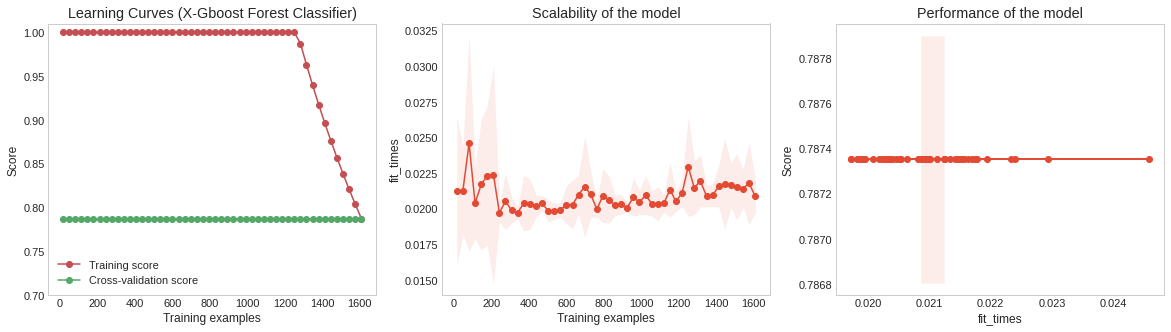

In [88]:
title = r"Learning Curves (X-Gboost Forest Classifier)"
# 
gbc = xgb.XGBClassifier(min_child_weight=1, subsample = 0.5,max_depth=3, random_state=42).fit(X_train, y_train)
estimator = clf 

plot_learning_curve(estimator, title, X, y, ylim=(0.7, 1.01), cv=10, n_jobs=-1, train_sizes=np.linspace(0.01, 1.0, 50))

plt.show()

## Classifier Comparison DataFrame

**Recall** ,**F1 Score** ,**Precision** 

In [96]:
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
f1_extra = f1_score(y_test, y_pred_tree, average= 'weighted')
f1_gbc = f1_score(y_test,y_pred_gbc, average= 'weighted')
f1_ran = f1_score(y_test, y_pred_ran, average= 'weighted')
f1_knn = f1_score(y_test,y_pred_knn, average=  'weighted')
precision_extra = precision_score(y_test, y_pred_tree, average= 'weighted')
precision_gbc = precision_score(y_test,y_pred_gbc, average= 'weighted')
precision_ran = precision_score(y_test, y_pred_ran, average= 'weighted')
precision_knn = precision_score(y_test, y_pred_ran,average = 'weighted' )
recall_gbc = recall_score(y_test, y_pred_gbc, average= 'weighted')
recall_ran = recall_score(y_test, y_pred_ran, average= 'weighted')
recall_extra = recall_score(y_test, y_pred_tree, average= 'weighted')
recall_knn = recall_score(y_test, y_pred_knn, average= 'weighted')


**Default models Recall, F1 and Precision**

In [97]:
default_p_gbc    = precision_score(y_test, d_gbc_y, average= 'weighted')
default_r_gbc    = recall_score(y_test, d_gbc_y, average= 'weighted')
default_f1_gbc   = f1_score(y_test, d_gbc_y, average= 'weighted')
default_p_extra   = precision_score(y_test, d_extra_y, average= 'weighted')
default_r_extra   = recall_score(y_test, d_extra_y, average= 'weighted')
default_f1_extra  = f1_score(y_test, d_extra_y,average= 'weighted')
default_p_ran   = precision_score(y_test,d_ran_y , average= 'weighted')
default_r_ran   = recall_score(y_test, d_ran_y, average= 'weighted')
default_f1_ran  = f1_score(y_test, d_ran_y, average= 'weighted')
default_p_knn   = precision_score(y_test, d_knn_y, average= 'weighted')
default_r_knn   = recall_score(y_test, d_knn_y, average= 'weighted')
default_f1_knn  = f1_score(y_test, d_knn_y, average= 'weighted')

**auc score**

**ROC Curve for X-G Boost**

In [98]:
# XGboost
configure_plotly_browser_state()

gsearch_gbc.fit(X, y)
y_scores = gsearch_gbc.predict_proba(X)

# One hot encode the labels in order to plot them
y_onehot = pd.get_dummies(y, columns=gsearch_gbc.classes_)

# Create an empty figure, and iteratively add new lines
# every time we compute a new class
fig = go.Figure()
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

for i in range(y_scores.shape[1]):
    y_true = y_onehot.iloc[:, i]
    y_score = y_scores[:, i]

    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc_score = roc_auc_score(y_true, y_score)

    name = f"{y_onehot.columns[i]} (AUC={auc_score:.2f})"
    fig.add_trace(go.Scatter(x=fpr, y=tpr, name=name, mode='lines'))

fig.update_layout(
    xaxis_title='False Positive Rate',
    yaxis_title='True Positive Rate',
    yaxis=dict(scaleanchor="x", scaleratio=1),
    xaxis=dict(constrain='domain'), title = 'ROC CURVE (X-GBOOST)',
    width=700, height=500
)
fig.show()

In [99]:
name = ['ExtraTreesClassifier', 'RandomForestClassifier',  'XgboostClassifier', 'KNNClassifier', 
        'Default_ExtraClassifier', 'Default_RandomForestClassifier', 'default_XgboostClassifier', 'default_KNNClassifier']

Time = [tree_time, ran_time, gbc_time, knn_time, d_extra_time, d_ran_time, d_gbc_time, d_knn_time]
accuracy = [extra_best_score, ran_best_score, gbc_best_score, knn_best_score, extra_acc,ran_acc,gbc_acc, knn_acc]
f1_Score = [f1_extra, f1_ran, f1_gbc, f1_knn, default_f1_extra, default_f1_ran,default_f1_gbc,default_f1_knn]
precision_score = [precision_extra,precision_ran, precision_gbc, precision_knn, default_p_extra,default_p_ran, default_p_gbc, default_p_knn]
recall = [recall_extra, recall_ran, recall_gbc, recall_knn, default_r_extra,default_r_ran,default_r_gbc,default_r_knn]


# Time is calcuated in seconds
list1 = list(zip( Time, accuracy, f1_Score, precision_score, recall))

cn = sns.light_palette( 'lime',as_cmap=True)

# Make a Dataframe
compare_df = pd.DataFrame(list1, columns= ['Prediction_Time', 'Accuracy_Score', 'f1', 'Precision', 'Recall'], index = name)
compare_df.sort_values(by = 'Accuracy_Score', ascending= False)

# coloring based on their performance
compare_df.style.background_gradient(cmap=cn)

,Prediction_Time,Accuracy_Score,f1,Precision,Recall
ExtraTreesClassifier,0.021078,81.730000,0.841644,0.848276,0.844444
RandomForestClassifier,2.645818,79.840000,0.844233,0.836389,0.866667
XgboostClassifier,0.004517,81.020000,0.832412,0.839048,0.833333
KNNClassifier,3.385811,78.000000,0.690278,0.836389,0.777778
Default_ExtraClassifier,0.126554,83.330000,0.788424,0.792725,0.833333
Default_RandomForestClassifier,0.155266,78.890000,0.695790,0.622346,0.788889
default_XgboostClassifier,0.145601,87.780000,0.875917,0.880137,0.877778
default_KNNClassifier,0.013343,76.670000,0.701358,0.670995,0.766667


In [100]:
configure_plotly_browser_state()

trace = [go.Table(
    header=dict(values=['Classifiers','Prediction_Time', 'Grid_search_Best_score','f1','Precision', 'Recall'],
                line = dict(color='#7D7F80'),
                fill = dict(color='mistyrose'),
                align = ['left'] * 5),
    cells=dict(values=[name,Time, accuracy, f1_Score, precision_score,recall],
               line = dict(color='pink'),
               fill = dict(color='lavender'),
               align = ['left'] * 5))]

layout = dict(width=1200, height=500)

fig = dict(data=trace, layout=layout)
iplot(fig, filename = 'ModelComparison_Table')

RandomForest training time is  high as compare to other models and randomforest grid search score is low as compare to other models.

# ROC Model Comparison after optimizing models with Hyperaparmeter Tunning.




In [101]:
# Optimised models data for generating ROC Curves.
configure_plotly_browser_state()
init_notebook_mode(connected= True)


gbc_model = xgb.XGBClassifier(max_depth = 3,min_child_weight = 1,subsample = 0.7,random_state=42).fit(X_train, y_train)
               
ran_model  = RandomForestClassifier(random_state = 42,criterion = 'gini',max_depth = 3, max_samples= 7, min_samples_leaf=1,min_samples_split=6,n_estimators = 7).fit(X_train, y_train)

extra_model = ExtraTreesClassifier(max_depth = 5, max_features = 4, min_samples_leaf = 1,min_samples_split = 5,random_state=42).fit(X_train, y_train)

knn_model = KNeighborsClassifier(n_neighbors= 3).fit(X_train, y_train)

# predict probabilities
pred_prob1 = gbc_model.predict_proba(X_test)
pred_prob2 = ran_model.predict_proba(X_test)
pred_prob3 = extra_model.predict_proba(X_test)
pred_prob4 = knn_model.predict_proba(X_test)

# ROC curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, pred_prob1[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, pred_prob2[:,1], pos_label=1)
fpr3, tpr3, thresh3 = roc_curve(y_test, pred_prob3[:,1], pos_label=1)
fpr4, tpr4, thresh4 = roc_curve(y_test, pred_prob4[:,1], pos_label=1)


auc_score1 = roc_auc_score(y, gbc_model.predict_proba(X), multi_class='ovr')
auc_score2 = roc_auc_score(y, ran_model.predict_proba(X), multi_class='ovr')
auc_score3  = roc_auc_score(y, extra_model.predict_proba(X), multi_class='ovr')
auc_score4  = roc_auc_score(y, knn_model.predict_proba(X), multi_class='ovr')

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)


**Code for ROC Figure**

In [102]:
fig = go.Figure()
configure_plotly_browser_state()

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

fig.add_trace(go.Scatter(x=fpr1, y = tpr1, mode='lines',     name='XGBoost (AUC = %0.3f)' % auc_score1))
fig.add_trace(go.Scatter(x = fpr2, y = tpr2, mode = 'lines' , name = 'RandomForest (AUC = %0.3f)' % auc_score2))
fig.add_trace(go.Scatter(x = fpr3, y = tpr3, mode = 'lines', name = 'ExtraTree (AUC = %0.3f)' % auc_score3))
fig.add_trace(go.Scatter(x = fpr3, y = tpr3, mode = 'lines', name = 'Kneigbour (AUC = %0.3f)' % auc_score4, marker=dict(
                color="gold",
                symbol='square-open'
            )))
fig.add_trace(go.Scatter(x = p_fpr, y = p_tpr, marker=dict(
                color="black",symbol='square' ), name = 'Baseline'))

fig.update_layout(title = 'Receiver operating Curve Analysis on Optimized Models',  font = dict(color = 'crimson') ,width = 750,height= 450, xaxis_title="False Positive Rate",
    yaxis_title="True Positive Rate",  legend=dict(
        x=0.64,
        y=0,
        traceorder="reversed", 
        ) )

fig.show()

**Observation from ROC curve XGBoost gives highest AUC as compare to other models.boosting method is good in making predictions more accuractly in this dataset.

# Classification Reports

**Classification Report Comparison Among Various Models**

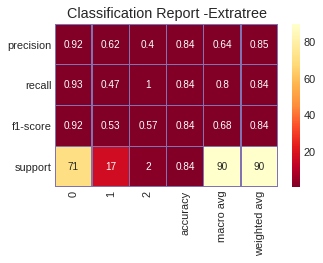

In [103]:
y_pred_extra = gsearch_extra.best_estimator_.predict(X_test)
tree_report = classification_report(y_test, y_pred_extra, output_dict=True)
plt.figure(figsize= (5,3))
sns.heatmap(pd.DataFrame(tree_report), annot=True, cmap= 'YlOrRd_r', linecolor='m', linewidths=0.5).set_title("Classification Report -Extratree")
plt.show()

In [104]:
gsearch_gbc

GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=None, objective='binary:logistic',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid=False, n_jobs=-1,
             param_grid={'max_depth': range(3, 20, 2),
                         'min_child_weight': range(1, 3),
                         'subsample': [0.5, 0.7]},
             pre_disp

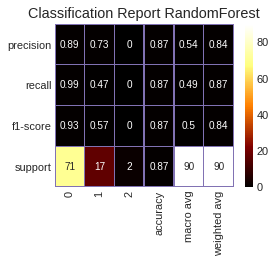

In [105]:
y_pred_ran = gsearch_ran.best_estimator_.predict(X_test)
ran_report = classification_report(y_test, y_pred_ran, output_dict=True)
plt.figure(figsize=(4,3))
sns.heatmap(pd.DataFrame(ran_report), annot=True, cmap= 'afmhot', linecolor='m', linewidths=0.5).set_title("Classification Report RandomForest")
plt.show()

# Ensemble Learning for Imporving the Calssifcation Models

the results of the different classifiers presented in the previous sections can be combined to improve the classification mode, 
 I use the `VotingClassifier` method of the `sklearn package`

In [112]:

tree_best  = ExtraTreesClassifier(**gsearch_extra.best_params_)

ran_best = RandomForestClassifier(**gsearch_ran.best_params_)

In [113]:
from sklearn.ensemble import VotingClassifier
votingC = VotingClassifier(estimators=[
    ('ran', ran_best),
                                                ('extra', tree_best)], voting='soft')  
votingC = votingC.fit(X_train, y_train)
p = votingC.predict(X_test)
accuracy_score(y_test, p)

0.8444444444444444

**Predictions**

In [114]:
predictions = votingC.predict(X_test) # testing part for testing accuracy.
print(" Test set Accuracy: {:.2f} % ".format(100*accuracy_score(y_test, predictions)))

 Test set Accuracy: 84.44 % 


**Why choose Random Forest:**

in classification, you do not need to get rid of collinear variables. These will influence your coefficients, but not your predictions. You can just leave them in.

random forest outperforms single decision tree, because it uses 2 techquies bagging and subspace sampling.  Both of them help random forest achieve one single philosophy — ‘wisdom of crowds’.




**why choose XGboost**




min_child_weight: Used to control over-fitting. Higher values prevent a model from learning relations which might be highly specific to the particular sample selected for a tree.

In [115]:
param_df = pd.concat([gbc_params_df, extra_params_df, ran_params_df, knn_params_df])

In [116]:
param_df  # list of all the used parameters at single place


,Xgboost_params,ExtraTree_params,RandomForest_params,knn_params
max_depth,3.0,NaN,NaN,NaN
min_child_weight,2.0,NaN,NaN,NaN
subsample,0.5,NaN,NaN,NaN
max_depth,NaN,7.0,NaN,NaN
max_features,NaN,8.0,NaN,NaN
min_samples_leaf,NaN,1.0,NaN,NaN
min_samples_split,NaN,3.0,NaN,NaN
criterion,NaN,NaN,gini,NaN
max_depth,NaN,NaN,3,NaN
max_samples,NaN,NaN,7,NaN
